# Feature Selection

Selected Features: Index(['AveragePlayerAge', 'TotalGoalsLastSeason', 'MatchesWonLastSeason',
       'MatchesDrawnLastSeason', 'MatchesLostLastSeason',
       'TotalGoalsConcededLastSeason', 'TotalRevenueLastSeason',
       'StadiumCapacity', 'AverageAttendance', 'TransferSpendingLastSeason',
       'TransferIncomeLastSeason', 'NumberOfTrophies', 'MarketValueOfSquad',
       'AveragePlayerMarketValue', 'YouthAcademyRating', 'Net_Goal_Difference',
       'Net_Wins', 'Effective_Points_Last_Season', 'Team_Efficiency',
       'League_encoded', 'TeamFormation_encoded', 'PlayingStyle_encoded',
       'HomeCity_encoded', 'StadiumType_encoded', 'KitManufacturer_encoded'],
      dtype='object')


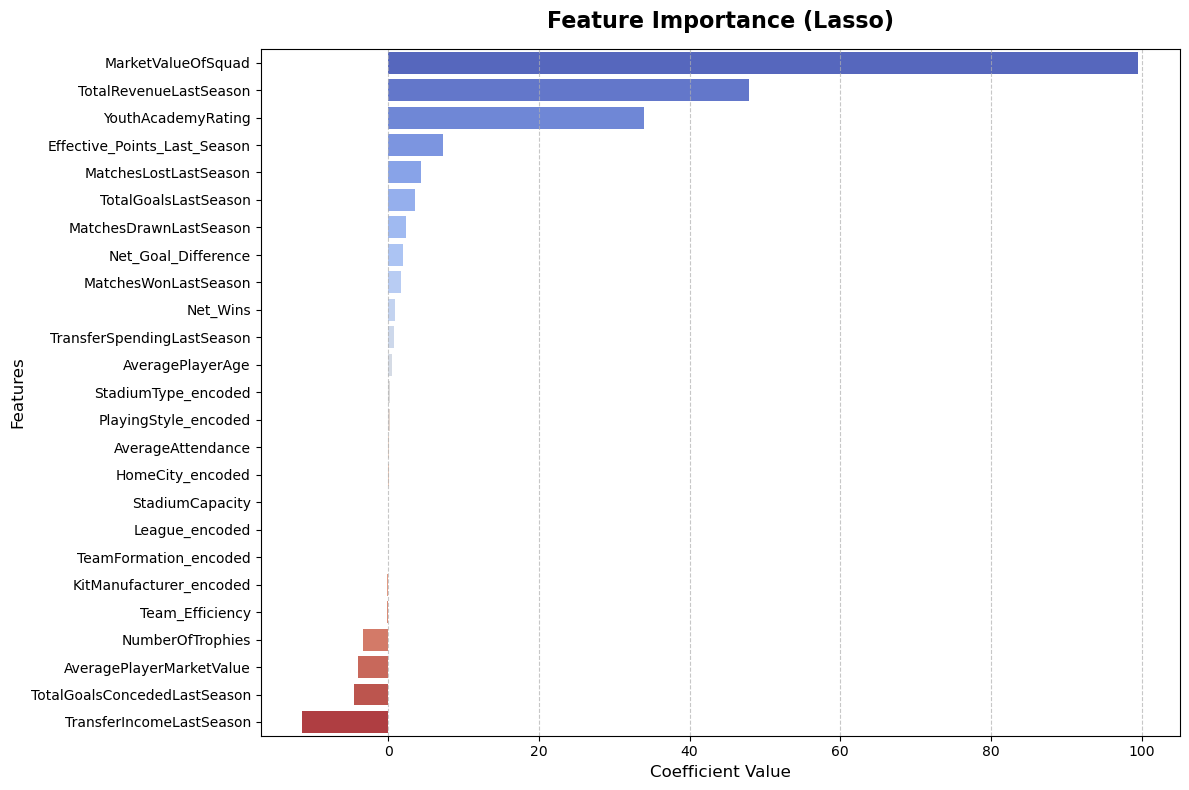

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import shap

data = pd.read_csv('/Users/easonwang/Desktop/Statistics/Final Project/result.csv')  
X = data.drop(columns=['Price']) 
y = data['Price']  

# Feature Selection using Lasso
lasso = LassoCV(cv=5, random_state=42, alphas=np.logspace(-3, 0, 50))
lasso.fit(X, y)
coef_threshold = 0.01
selected_features = X.columns[np.abs(lasso.coef_) > coef_threshold]
print("Selected Features:", selected_features)

# Generate a feature importance DataFrame
important_features = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
}).query("abs(Coefficient) > @coef_threshold").sort_values(by='Coefficient', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(
    data=important_features,
    y='Feature',
    x='Coefficient',
    palette='coolwarm',
    orient='h'
)
plt.title("Feature Importance (Lasso)", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Update X with selected features
X = X[selected_features]

# Cluster Analysis

Cluster Distribution:
 1    37154
-1    12834
 0       12
Name: Cluster_Label, dtype: int64


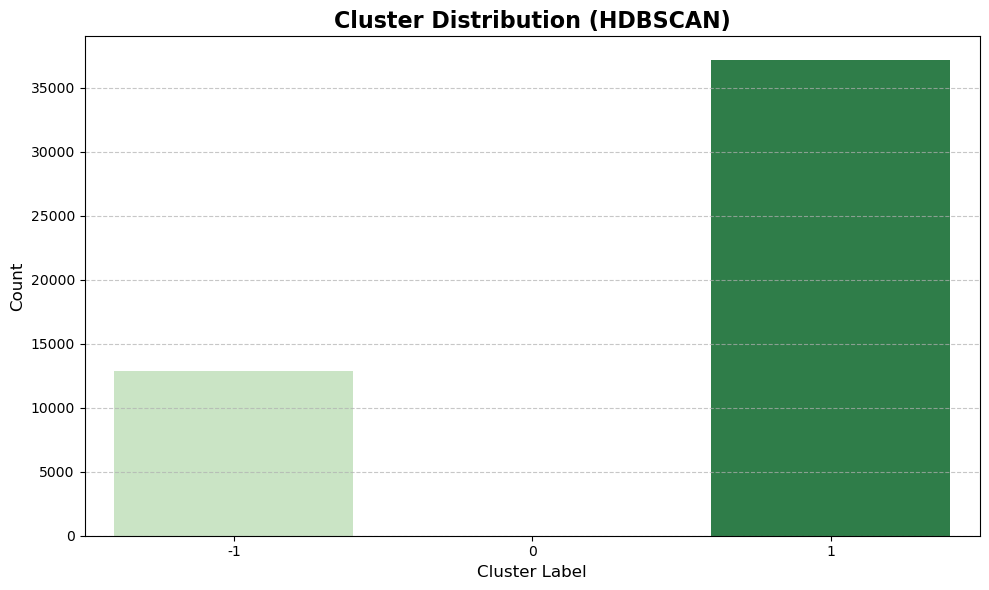

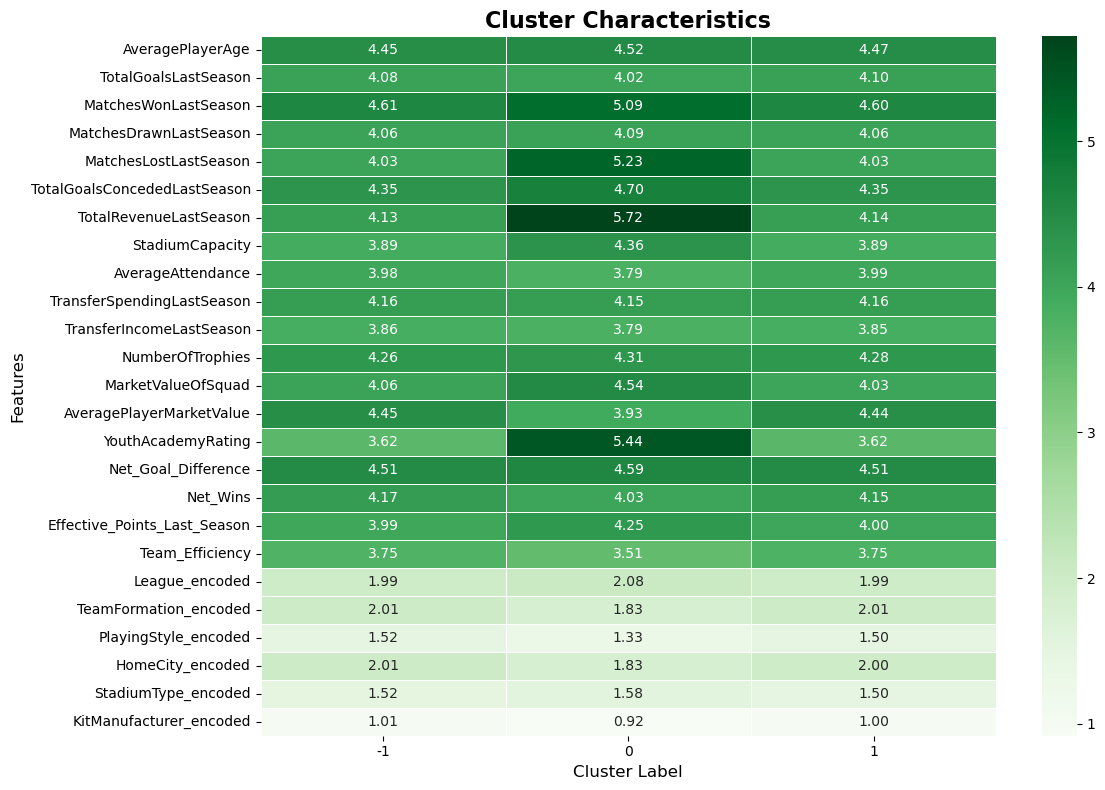

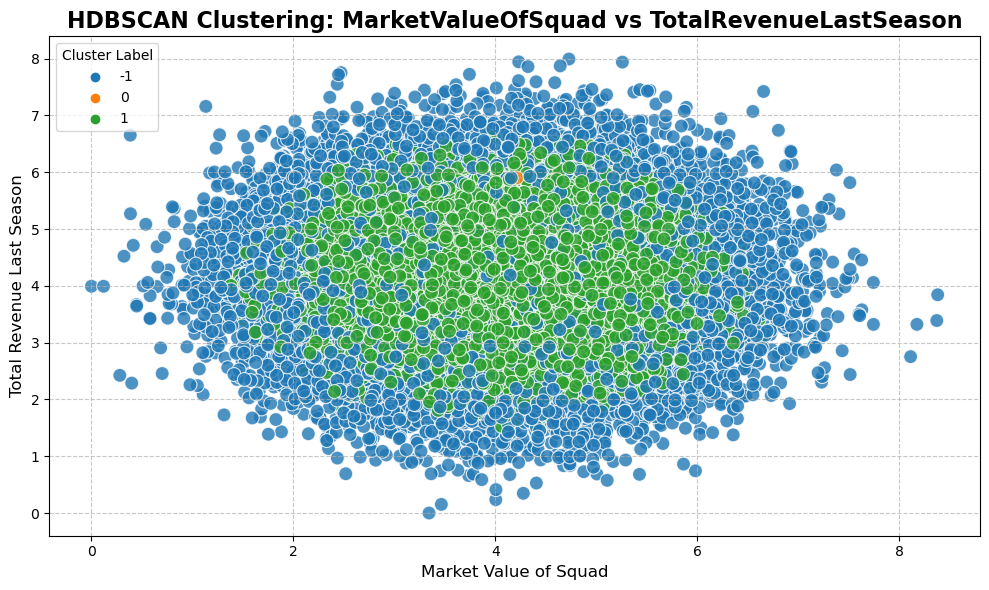

In [3]:
import hdbscan
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting features for clustering
selected_columns = [
    'MarketValueOfSquad', 'TotalRevenueLastSeason', 'YouthAcademyRating', 
    'Effective_Points_Last_Season', 'MatchesLostLastSeason'
]
X_selected = X[selected_columns]

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Fitting HDBSCAN model
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=10, min_samples=3, metric='euclidean', 
    cluster_selection_method='eom'
)
cluster_labels = hdbscan_model.fit_predict(X_scaled)
X['Cluster_Label'] = cluster_labels

# Printing cluster distribution
print("Cluster Distribution:")
print(X['Cluster_Label'].value_counts())

# Cluster distribution visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster_Label', data=X, palette='Greens')
plt.title("Cluster Distribution (HDBSCAN)", fontsize=16, fontweight='bold')
plt.xlabel("Cluster Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Analyzing cluster characteristics
cluster_means = X.groupby('Cluster_Label').mean()

# Heatmap for cluster characteristics
plt.figure(figsize=(12, 8))
sns.heatmap(
    cluster_means.T, 
    cmap='Greens',  
    annot=True, 
    fmt=".2f", 
    linewidths=0.5,  
    linecolor='white'
)
plt.title("Cluster Characteristics", fontsize=16, fontweight='bold')
plt.xlabel("Cluster Label", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

# Scatter plot for cluster visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X['MarketValueOfSquad'], 
    y=X['TotalRevenueLastSeason'], 
    hue=X['Cluster_Label'], 
    palette='tab10', 
    s=100, 
    alpha=0.8
)
plt.title("HDBSCAN Clustering: MarketValueOfSquad vs TotalRevenueLastSeason", fontsize=16, fontweight='bold')
plt.xlabel("Market Value of Squad", fontsize=12)
plt.ylabel("Total Revenue Last Season", fontsize=12)
plt.legend(title="Cluster Label", fontsize=10, loc='upper left')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Model Selection

In [6]:
import time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Selection
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'SVR': SVR(),
    'MLP': MLPRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test_scaled)
    pred_time = time.time() - start_time

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2, 'TrainTime': train_time, 'PredTime': pred_time}
    print(f"{name}: MSE={mse}, MAE={mae}, R2={r2}, TrainTime={train_time:.4f}s, PredTime={pred_time:.4f}s")

RandomForest: MSE=2761.193473460286, MAE=41.8881956628989, R2=0.8314332263599249, TrainTime=44.1132s, PredTime=0.1897s
XGBoost: MSE=2798.2840796940063, MAE=42.19819135109597, R2=0.8291688997615654, TrainTime=0.1783s, PredTime=0.0032s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4881
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
LightGBM: MSE=2614.747168404624, MAE=40.746856753467746, R2=0.8403735564715296, TrainTime=0.2417s, PredTime=0.0084s
CatBoost: MSE=2569.8492145832047, MAE=40.42843259358621, R2=0.8431145100814311, TrainTime=2.1416s, PredTime=0.0035s
SVR: MSE=3520.1125880731956, MAE=46.452724286368245, R2=0.7851023379836887, TrainTime=25.2401s, PredTime=10.5105s


/Users/easonwang/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP: MSE=2640.671796119745, MAE=41.07158731227738, R2=0.8387908963306298, TrainTime=21.4822s, PredTime=0.0039s
AdaBoost: MSE=3194.3376151279585, MAE=45.02505452904281, R2=0.8049904177759544, TrainTime=5.2106s, PredTime=0.0238s


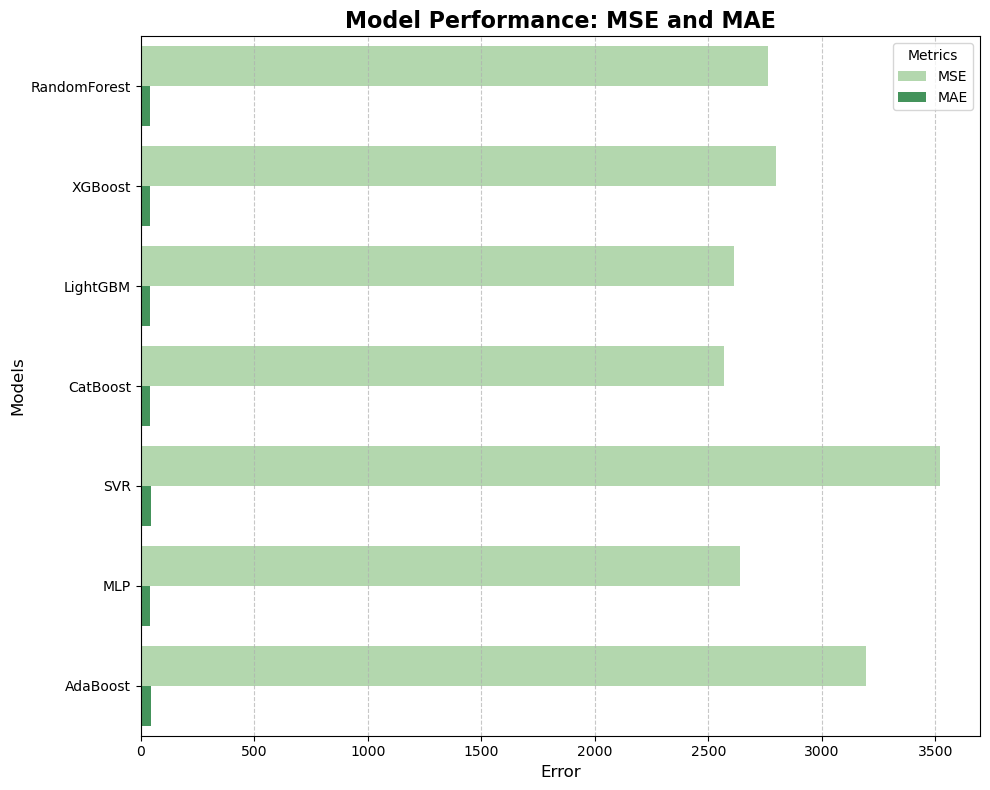

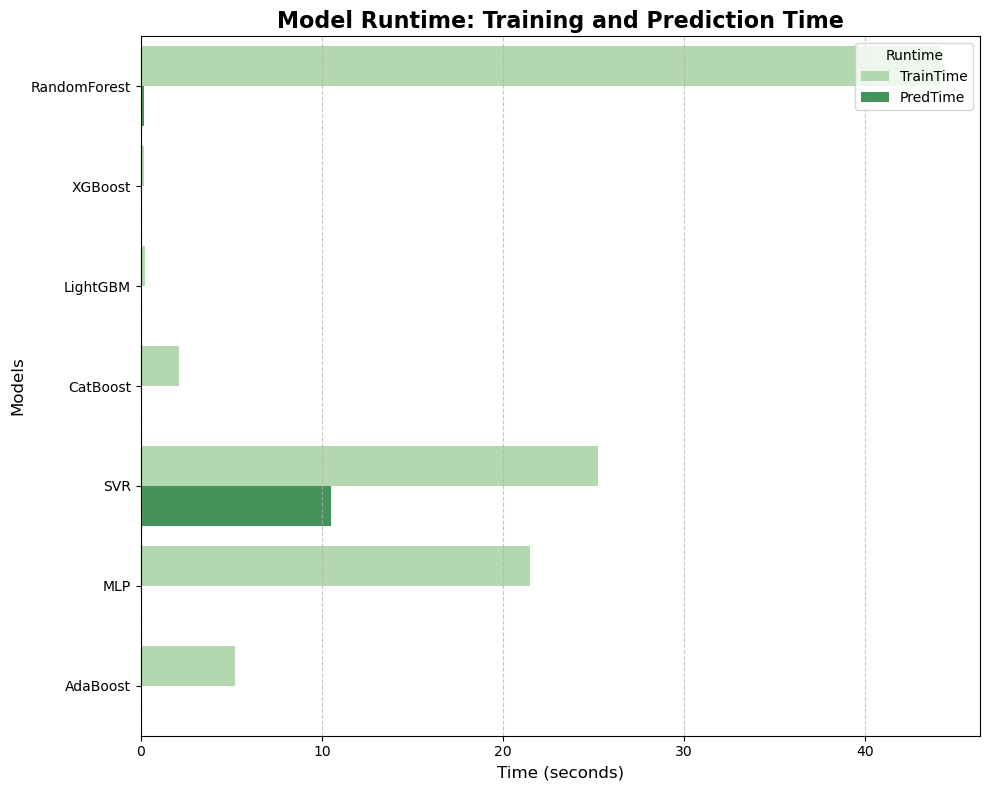

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

performance_df = pd.DataFrame(results).T
performance_melted = performance_df[['MSE', 'MAE', 'R2']].reset_index().melt(id_vars='index')
runtime_melted = performance_df[['TrainTime', 'PredTime']].reset_index().melt(id_vars='index')

sns.set_palette("Greens")
# Performance Plot: MSE and MAE
plt.figure(figsize=(10, 8))
sns.barplot(
    data=performance_melted[performance_melted['variable'].isin(['MSE', 'MAE'])],
    y='index', x='value', hue='variable', palette='Greens', orient='h'
)
plt.title("Model Performance: MSE and MAE", fontsize=16, fontweight='bold')
plt.xlabel("Error", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.legend(title="Metrics", fontsize=10, loc='upper right')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Runtime Plot: Training and Prediction Time
plt.figure(figsize=(10, 8))
sns.barplot(
    data=runtime_melted,
    y='index', x='value', hue='variable', palette='Greens', orient='h'
)
plt.title("Model Runtime: Training and Prediction Time", fontsize=16, fontweight='bold')
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.legend(title="Runtime", fontsize=10, loc='upper right')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


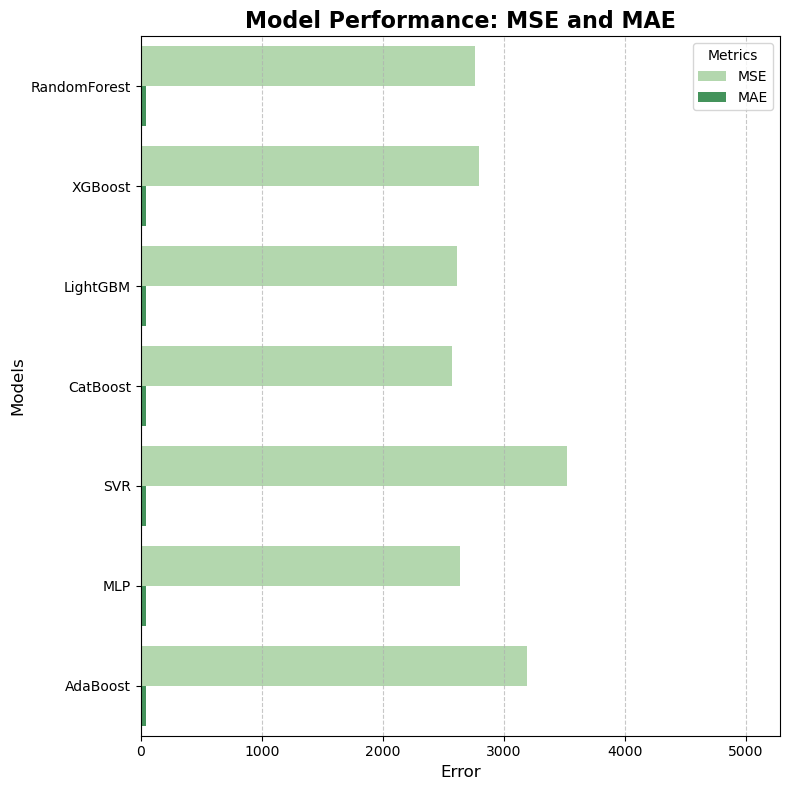

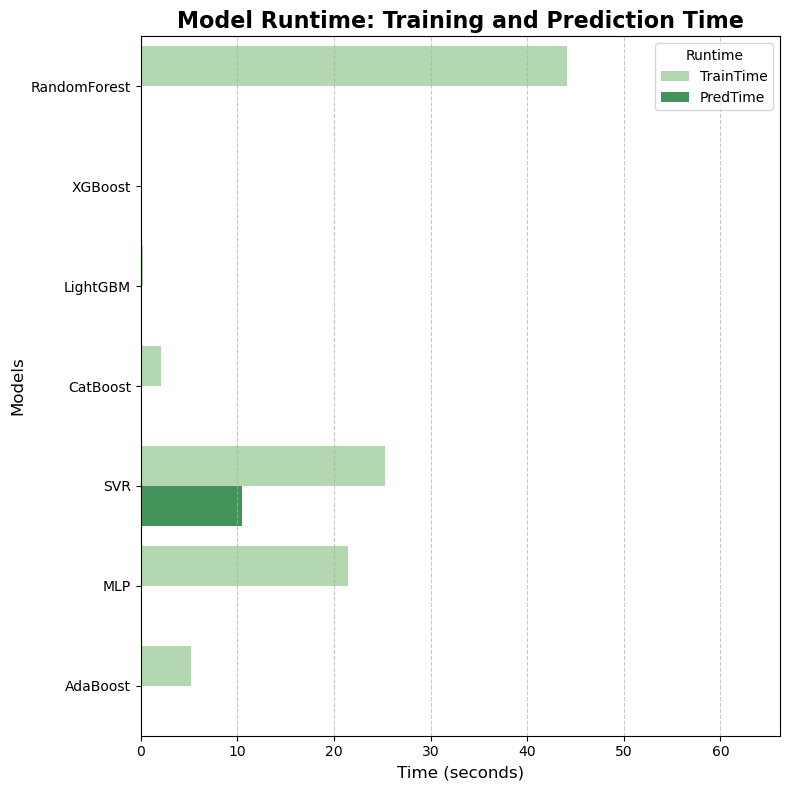

In [15]:
sns.set_palette("Greens")

# Performance Plot: MSE and MAE
plt.figure(figsize=(8, 8))  # Adjust the width for a smaller figure
sns.barplot(
    data=performance_melted[performance_melted['variable'].isin(['MSE', 'MAE'])],
    y='index', x='value', hue='variable', palette='Greens', orient='h'
)
plt.title("Model Performance: MSE and MAE", fontsize=16, fontweight='bold')
plt.xlabel("Error", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.xlim(0, 1.5 * performance_melted['value'].max())  # Add truncation to limit x-axis
plt.legend(title="Metrics", fontsize=10, loc='upper right')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Runtime Plot: Training and Prediction Time
plt.figure(figsize=(8, 8))  # Adjust the width for a smaller figure
sns.barplot(
    data=runtime_melted,
    y='index', x='value', hue='variable', palette='Greens', orient='h'
)
plt.title("Model Runtime: Training and Prediction Time", fontsize=16, fontweight='bold')
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.xlim(0, 1.5 * runtime_melted['value'].max())  # Add truncation to limit x-axis
plt.legend(title="Runtime", fontsize=10, loc='upper right')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# Improvement

In [16]:
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV
import optuna
import shap

lgbm_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(LGBMRegressor(random_state=42), lgbm_params, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)
best_lgbm = grid_search.best_estimator_


def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100)
    }
    model = LGBMRegressor(random_state=42, **params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return r2_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
optimized_params = study.best_params
best_lgbm_optuna = LGBMRegressor(random_state=42, **optimized_params)
best_lgbm_optuna.fit(X_train, y_train)

# Stacking
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor

stacking_model = StackingRegressor(
    estimators=[
        ('lgbm', best_lgbm_optuna),
        ('ridge', RidgeCV(cv=5)),
        ('rf', RandomForestRegressor(random_state=42, n_estimators=100))
    ],
    final_estimator=LGBMRegressor(random_state=42)
)
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)
print(f"Stacking Model: MSE={mean_squared_error(y_test, y_pred_stacking):.2f}, MAE={mean_absolute_error(y_test, y_pred_stacking):.2f}, R²={r2_score(y_test, y_pred_stacking):.2f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 26666, number of used features: 26
[LightGBM] [Info] Start training from score 719.456066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-09 20:01:23,733] A new study created in memory with name: no-name-d1061eb9-d72a-4ef1-a521-d2260800afea


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-12-09 20:01:23,851] Trial 0 finished with value: 0.8392365950235862 and parameters: {'n_estimators': 80, 'learning_rate': 0.20043543146202342, 'max_depth': 4, 'num_leaves': 98}. Best is trial 0 with value: 0.8392365950235862.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train s

[I 2024-12-09 20:01:24,096] Trial 1 finished with value: 0.8398621902750932 and parameters: {'n_estimators': 132, 'learning_rate': 0.10830122223397418, 'max_depth': 10, 'num_leaves': 35}. Best is trial 1 with value: 0.8398621902750932.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-12-09 20:01:24,387] Trial 2 finished with value: 0.8380201027212295 and parameters: {'n_estimators': 364, 'learning_rate': 0.15883672876328161, 'max_depth': 4, 'num_leaves': 52}. Best is trial 1 with value: 0.8398621902750932.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:24,731] Trial 3 finished with value: 0.8316015156345846 and parameters: {'n_estimators': 206, 'learning_rate': 0.20105909942008726, 'max_depth': 6, 'num_leaves': 61}. Best is trial 1 with value: 0.8398621902750932.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:25,040] Trial 4 finished with value: 0.8344634399281449 and parameters: {'n_estimators': 498, 'learning_rate': 0.290190793157415, 'max_depth': 3, 'num_leaves': 25}. Best is trial 1 with value: 0.8398621902750932.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:25,241] Trial 5 finished with value: 0.84096457417074 and parameters: {'n_estimators': 137, 'learning_rate': 0.10313791061901023, 'max_depth': 5, 'num_leaves': 40}. Best is trial 5 with value: 0.84096457417074.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:25,997] Trial 6 finished with value: 0.8411414280449869 and parameters: {'n_estimators': 296, 'learning_rate': 0.026570869232084217, 'max_depth': 7, 'num_leaves': 62}. Best is trial 6 with value: 0.8411414280449869.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-12-09 20:01:26,404] Trial 7 finished with value: 0.8279505812828365 and parameters: {'n_estimators': 256, 'learning_rate': 0.274096056900839, 'max_depth': 5, 'num_leaves': 91}. Best is trial 6 with value: 0.8411414280449869.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:26,864] Trial 8 finished with value: 0.8396141773186907 and parameters: {'n_estimators': 255, 'learning_rate': 0.0849761654344146, 'max_depth': 8, 'num_leaves': 40}. Best is trial 6 with value: 0.8411414280449869.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962


[I 2024-12-09 20:01:27,515] Trial 9 finished with value: 0.8407918571221145 and parameters: {'n_estimators': 449, 'learning_rate': 0.06429378382523801, 'max_depth': 7, 'num_leaves': 21}. Best is trial 6 with value: 0.8411414280449869.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962


[I 2024-12-09 20:01:28,967] Trial 10 finished with value: 0.8372094929131002 and parameters: {'n_estimators': 345, 'learning_rate': 0.011724499459381216, 'max_depth': 9, 'num_leaves': 74}. Best is trial 6 with value: 0.8411414280449869.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-09 20:01:29,807] Trial 11 finished with value: 0.8404742860378647 and parameters: {'n_estimators': 344, 'learning_rate': 0.018377104136161476, 'max_depth': 6, 'num_leaves': 65}. Best is trial 6 with value: 0.8411414280449869.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:30,190] Trial 12 finished with value: 0.8368114306821972 and parameters: {'n_estimators': 178, 'learning_rate': 0.1282754865613667, 'max_depth': 7, 'num_leaves': 46}. Best is trial 6 with value: 0.8411414280449869.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-09 20:01:30,325] Trial 13 finished with value: 0.8207237313983355 and parameters: {'n_estimators': 51, 'learning_rate': 0.05577982832726273, 'max_depth': 5, 'num_leaves': 77}. Best is trial 6 with value: 0.8411414280449869.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:30,824] Trial 14 finished with value: 0.8398174104220643 and parameters: {'n_estimators': 146, 'learning_rate': 0.03779362051943748, 'max_depth': 8, 'num_leaves': 53}. Best is trial 6 with value: 0.8411414280449869.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-12-09 20:01:31,292] Trial 15 finished with value: 0.8362876510701158 and parameters: {'n_estimators': 291, 'learning_rate': 0.14863419621602872, 'max_depth': 5, 'num_leaves': 35}. Best is trial 6 with value: 0.8411414280449869.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-09 20:01:31,861] Trial 16 finished with value: 0.8371360724863892 and parameters: {'n_estimators': 227, 'learning_rate': 0.08839060323628199, 'max_depth': 8, 'num_leaves': 72}. Best is trial 6 with value: 0.8411414280449869.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-09 20:01:32,103] Trial 17 finished with value: 0.8401712899603936 and parameters: {'n_estimators': 307, 'learning_rate': 0.18811986453079604, 'max_depth': 3, 'num_leaves': 54}. Best is trial 6 with value: 0.8411414280449869.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:32,995] Trial 18 finished with value: 0.8204322772372965 and parameters: {'n_estimators': 419, 'learning_rate': 0.24584467892998202, 'max_depth': 6, 'num_leaves': 84}. Best is trial 6 with value: 0.8411414280449869.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-09 20:01:33,265] Trial 19 finished with value: 0.8400654527656639 and parameters: {'n_estimators': 105, 'learning_rate': 0.057245440017536245, 'max_depth': 7, 'num_leaves': 65}. Best is trial 6 with value: 0.8411414280449869.
[I 2024-12-09 20:01:33,444] Trial 20 finished with value: 0.8418893784611999 and parameters: {'n_estimators': 176, 'learning_rate': 0.11220557120708738, 'max_depth': 4, 'num_leaves': 45}. Best is trial 20 with value: 0.8418893784611999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-12-09 20:01:33,624] Trial 21 finished with value: 0.8415794468135457 and parameters: {'n_estimators': 166, 'learning_rate': 0.11023331272782837, 'max_depth': 4, 'num_leaves': 44}. Best is trial 20 with value: 0.8418893784611999.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-12-09 20:01:33,810] Trial 22 finished with value: 0.8417667496014184 and parameters: {'n_estimators': 181, 'learning_rate': 0.13360934850236925, 'max_depth': 4, 'num_leaves': 47}. Best is trial 20 with value: 0.8418893784611999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:34,016] Trial 23 finished with value: 0.8416239725668186 and parameters: {'n_estimators': 183, 'learning_rate': 0.13312093443521, 'max_depth': 4, 'num_leaves': 30}. Best is trial 20 with value: 0.8418893784611999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:34,177] Trial 24 finished with value: 0.8418518980919658 and parameters: {'n_estimators': 205, 'learning_rate': 0.16363390068681824, 'max_depth': 3, 'num_leaves': 30}. Best is trial 20 with value: 0.8418893784611999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:34,346] Trial 25 finished with value: 0.8406943000734461 and parameters: {'n_estimators': 219, 'learning_rate': 0.18060393623709564, 'max_depth': 3, 'num_leaves': 29}. Best is trial 20 with value: 0.8418893784611999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:34,519] Trial 26 finished with value: 0.841747818774583 and parameters: {'n_estimators': 243, 'learning_rate': 0.15980926904084522, 'max_depth': 3, 'num_leaves': 49}. Best is trial 20 with value: 0.8418893784611999.
[I 2024-12-09 20:01:34,651] Trial 27 finished with value: 0.8399649708965329 and parameters: {'n_estimators': 110, 'learning_rate': 0.22598993457012098, 'max_depth': 4, 'num_leaves': 36}. Best is trial 20 with value: 0.8418893784611999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:34,809] Trial 28 finished with value: 0.8422200597457845 and parameters: {'n_estimators': 196, 'learning_rate': 0.14298429035408317, 'max_depth': 3, 'num_leaves': 56}. Best is trial 28 with value: 0.8422200597457845.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:34,913] Trial 29 finished with value: 0.8404358797753646 and parameters: {'n_estimators': 88, 'learning_rate': 0.21176003731893747, 'max_depth': 3, 'num_leaves': 20}. Best is trial 28 with value: 0.8422200597457845.
[I 2024-12-09 20:01:35,092] Trial 30 finished with value: 0.8416472311775318 and parameters: {'n_estimators': 209, 'learning_rate': 0.18634540524513843, 'max_depth': 3, 'num_leaves': 56}. Best is trial 28 with value: 0.8422200597457845.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:35,286] Trial 31 finished with value: 0.8413925484340772 and parameters: {'n_estimators': 188, 'learning_rate': 0.1279201380077697, 'max_depth': 4, 'num_leaves': 44}. Best is trial 28 with value: 0.8422200597457845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-12-09 20:01:35,466] Trial 32 finished with value: 0.8409783077401709 and parameters: {'n_estimators': 145, 'learning_rate': 0.1474815429202978, 'max_depth': 4, 'num_leaves': 31}. Best is trial 28 with value: 0.8422200597457845.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:35,611] Trial 33 finished with value: 0.8417945678896565 and parameters: {'n_estimators': 166, 'learning_rate': 0.1619156019855355, 'max_depth': 3, 'num_leaves': 49}. Best is trial 28 with value: 0.8422200597457845.
[I 2024-12-09 20:01:35,706] Trial 34 finished with value: 0.841859277080593 and parameters: {'n_estimators': 115, 'learning_rate': 0.1598346919796809, 'max_depth': 3, 'num_leaves': 40}. Best is trial 28 with value: 0.8422200597457845.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:35,799] Trial 35 finished with value: 0.840051791577497 and parameters: {'n_estimators': 72, 'learning_rate': 0.17177605542363894, 'max_depth': 3, 'num_leaves': 36}. Best is trial 28 with value: 0.8422200597457845.
[I 2024-12-09 20:01:35,917] Trial 36 finished with value: 0.8414856285807129 and parameters: {'n_estimators': 115, 'learning_rate': 0.1146409014455568, 'max_depth': 3, 'num_leaves': 40}. Best is trial 28 with value: 0.8422200597457845.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-09 20:01:36,089] Trial 37 finished with value: 0.8422946307421048 and parameters: {'n_estimators': 137, 'learning_rate': 0.09253779051706609, 'max_depth': 4, 'num_leaves': 58}. Best is trial 37 with value: 0.8422946307421048.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-09 20:01:36,302] Trial 38 finished with value: 0.8412673682006402 and parameters: {'n_estimators': 132, 'learning_rate': 0.0850426829313094, 'max_depth': 5, 'num_leaves': 59}. Best is trial 37 with value: 0.8422946307421048.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:36,569] Trial 39 finished with value: 0.8394166588010482 and parameters: {'n_estimators': 76, 'learning_rate': 0.09592743069573546, 'max_depth': 10, 'num_leaves': 59}. Best is trial 37 with value: 0.8422946307421048.
[I 2024-12-09 20:01:36,724] Trial 40 finished with value: 0.8413151794664908 and parameters: {'n_estimators': 149, 'learning_rate': 0.06903183336628868, 'max_depth': 4, 'num_leaves': 66}. Best is trial 37 with value: 0.8422946307421048.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-12-09 20:01:36,921] Trial 41 finished with value: 0.8412882676626466 and parameters: {'n_estimators': 198, 'learning_rate': 0.1181045066321305, 'max_depth': 4, 'num_leaves': 42}. Best is trial 37 with value: 0.8422946307421048.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:37,096] Trial 42 finished with value: 0.8416801436662664 and parameters: {'n_estimators': 240, 'learning_rate': 0.14515657893991074, 'max_depth': 3, 'num_leaves': 25}. Best is trial 37 with value: 0.8422946307421048.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:37,476] Trial 43 finished with value: 0.8366183033908625 and parameters: {'n_estimators': 272, 'learning_rate': 0.16837389999830607, 'max_depth': 5, 'num_leaves': 52}. Best is trial 37 with value: 0.8422946307421048.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:37,623] Trial 44 finished with value: 0.8394980847820273 and parameters: {'n_estimators': 134, 'learning_rate': 0.20386614900408748, 'max_depth': 4, 'num_leaves': 97}. Best is trial 37 with value: 0.8422946307421048.
[I 2024-12-09 20:01:37,715] Trial 45 finished with value: 0.8365684773689159 and parameters: {'n_estimators': 102, 'learning_rate': 0.07714537169235577, 'max_depth': 3, 'num_leaves': 70}. Best is trial 37 with value: 0.8422946307421048.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-12-09 20:01:37,983] Trial 46 finished with value: 0.8404621700730704 and parameters: {'n_estimators': 204, 'learning_rate': 0.10123768926166331, 'max_depth': 5, 'num_leaves': 39}. Best is trial 37 with value: 0.8422946307421048.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-09 20:01:38,228] Trial 47 finished with value: 0.8388920248953561 and parameters: {'n_estimators': 153, 'learning_rate': 0.1420791095107535, 'max_depth': 6, 'num_leaves': 27}. Best is trial 37 with value: 0.8422946307421048.
[I 2024-12-09 20:01:38,300] Trial 48 finished with value: 0.8302611782164898 and parameters: {'n_estimators': 50, 'learning_rate': 0.11880817985730945, 'max_depth': 3, 'num_leaves': 56}. Best is trial 37 with value: 0.8422946307421048.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-09 20:01:38,467] Trial 49 finished with value: 0.8396038511734044 and parameters: {'n_estimators': 166, 'learning_rate': 0.1758825986348384, 'max_depth': 4, 'num_leaves': 33}. Best is trial 37 with value: 0.8422946307421048.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4874
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score 718.768962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

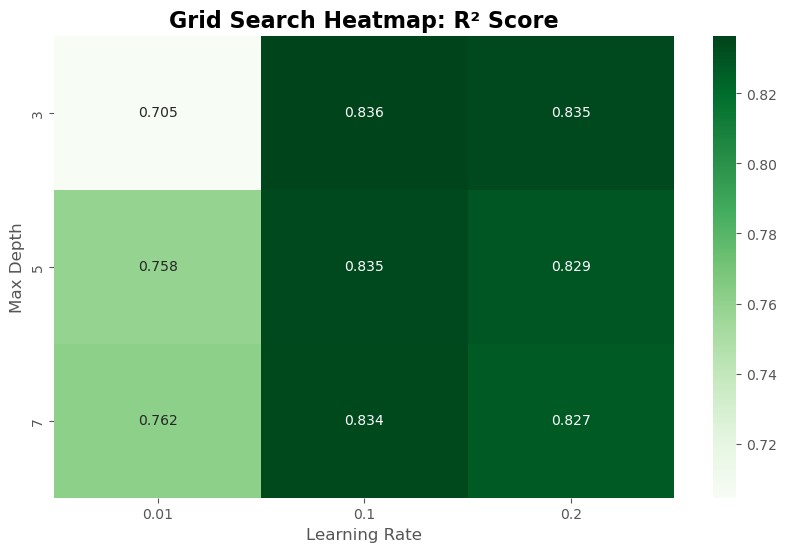

/var/folders/t8/78l36wb51dxf9t_qkrhc0pc00000gn/T/ipykernel_9802/812471790.py:21: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


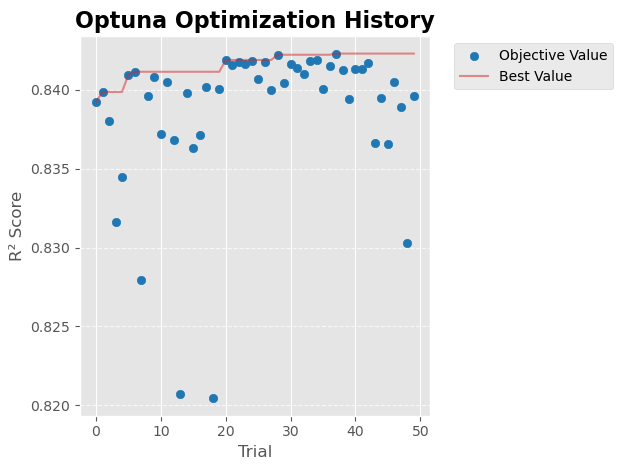

/var/folders/t8/78l36wb51dxf9t_qkrhc0pc00000gn/T/ipykernel_9802/812471790.py:30: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


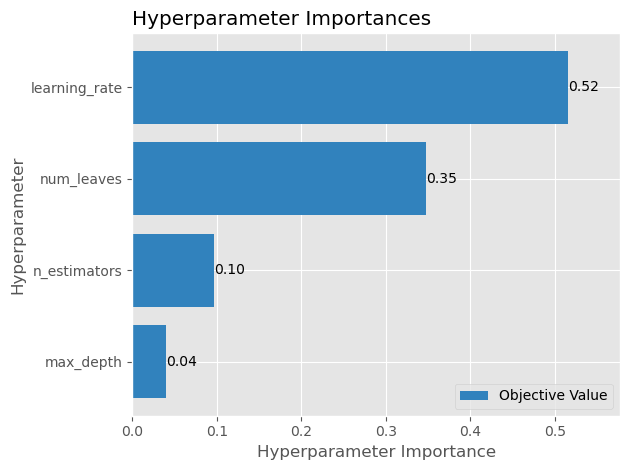

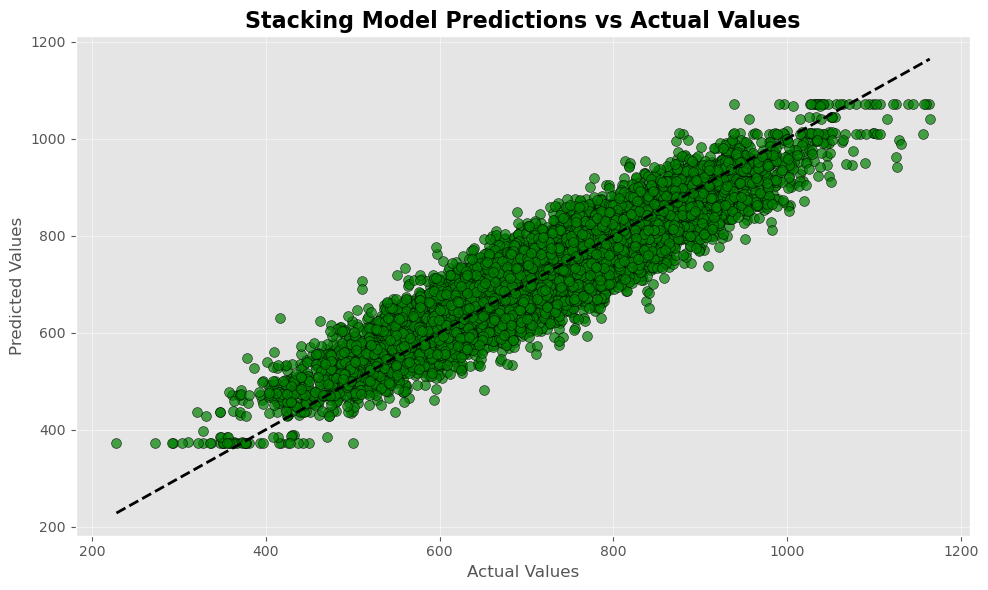

In [28]:
# Extract GridSearch results for visualization
grid_results = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(10, 6))
sns.heatmap(
    grid_results.pivot_table(
        values='mean_test_score',
        index='param_max_depth',
        columns='param_learning_rate'
    ),
    annot=True,
    fmt=".3f",
    cmap="Greens"
)
plt.title("Grid Search Heatmap: R² Score", fontsize=16, fontweight='bold')
plt.xlabel("Learning Rate", fontsize=12)
plt.ylabel("Max Depth", fontsize=12)
plt.show()

# Optuna Optimization Plot
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optuna Optimization History", fontsize=16, fontweight='bold')
plt.xlabel("Trial", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Parameter Importance Plot
optuna.visualization.matplotlib.plot_param_importances(study)
plt.tight_layout()
plt.show()

# Compare predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_stacking, alpha=0.7, color="Green", edgecolors="k", s=50)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="Black", lw=2, linestyle="--")
plt.title("Stacking Model Predictions vs Actual Values", fontsize=16, fontweight='bold')
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


 98%|===================| 9850/10000 [00:25<00:00]        

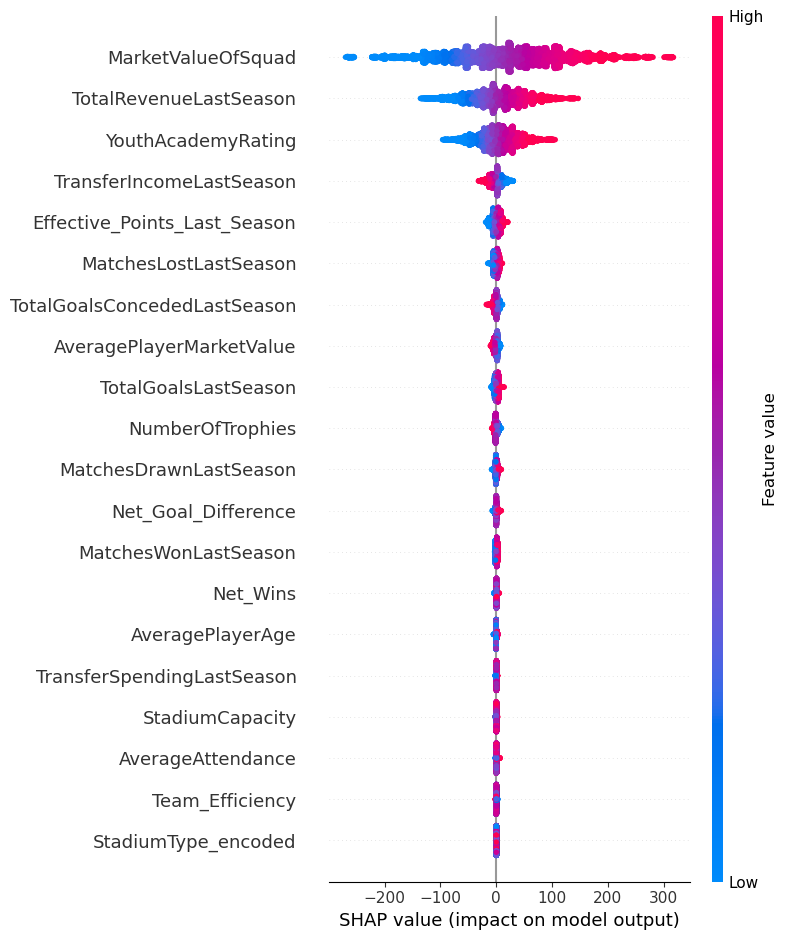

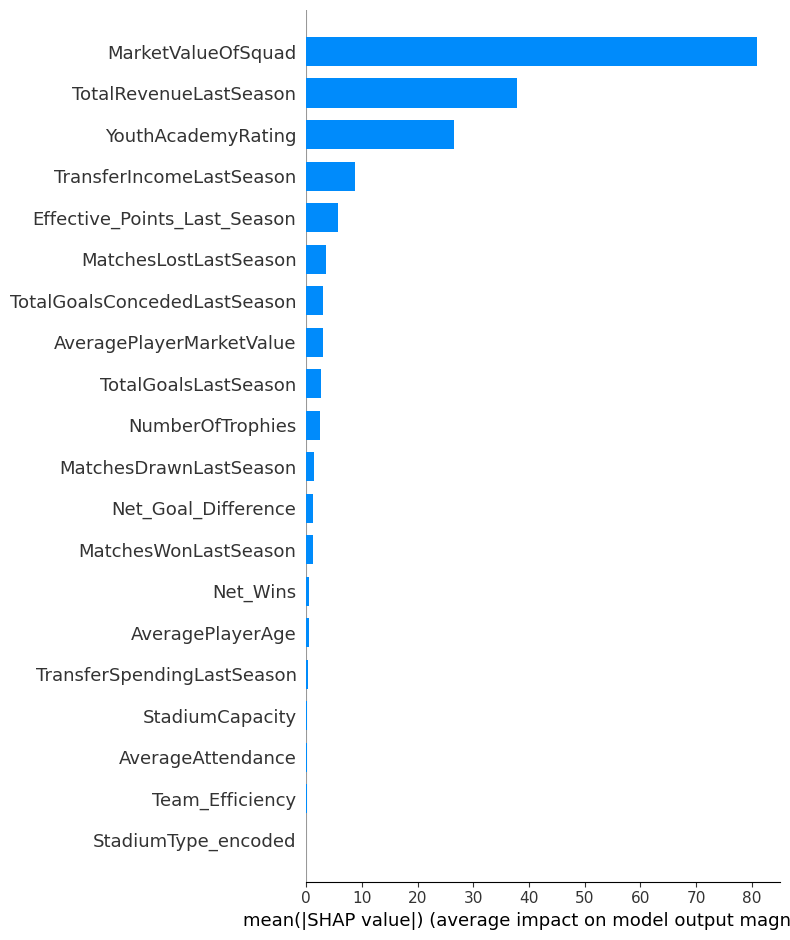

In [49]:
explainer = shap.Explainer(best_lgbm_optuna, X_train)  
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

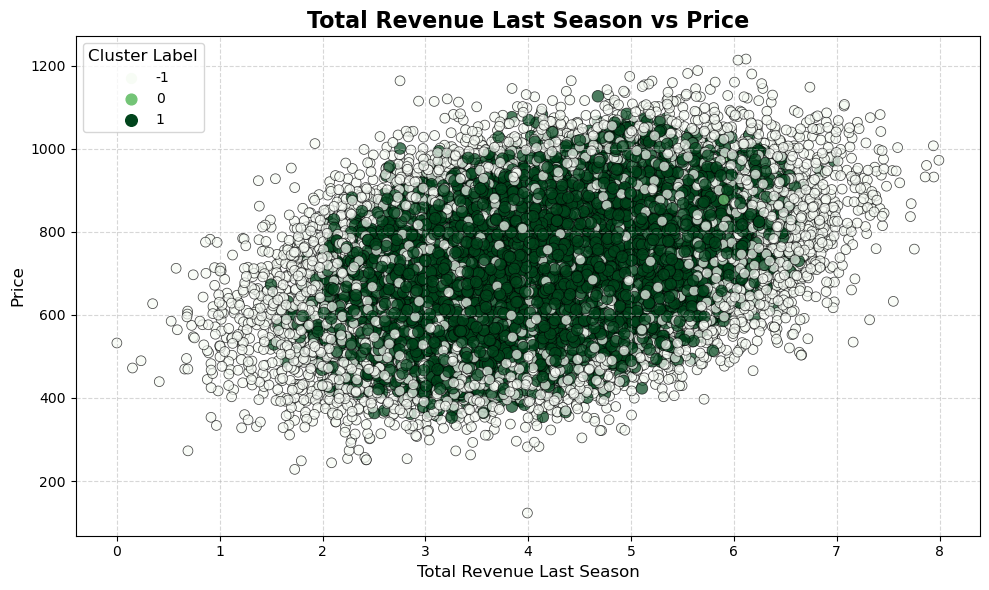

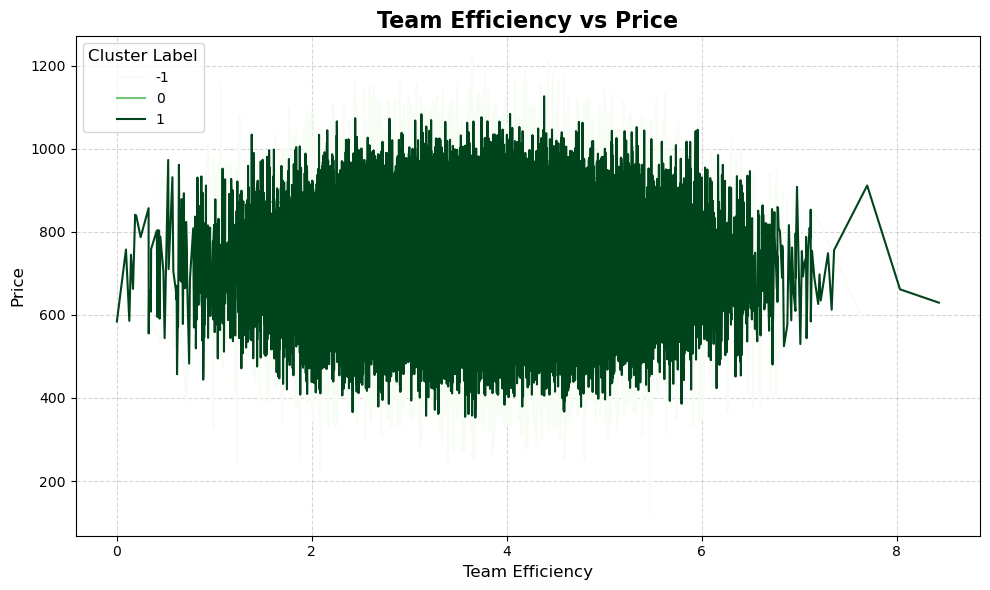

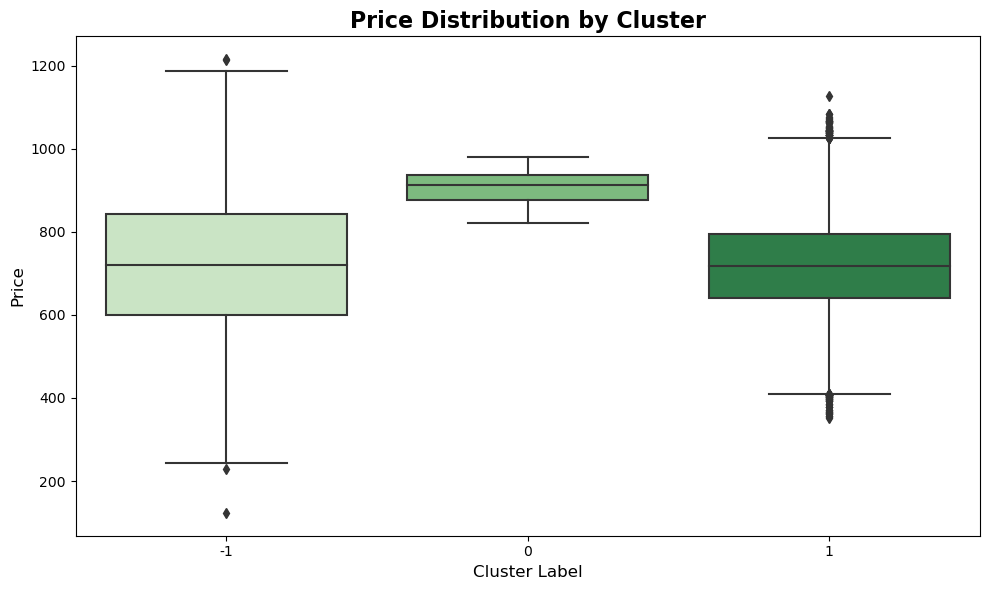

In [71]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='TotalRevenueLastSeason', 
    y='Price', 
    hue='Cluster_Label', 
    data=X.assign(Price=y),  
    palette='Greens',        
    alpha=0.7,               
    size='Cluster_Label',    
    sizes={-1: 50, 0: 60, 1: 70}, 
    edgecolor='black'        
)

plt.title("Total Revenue Last Season vs Price", fontsize=16, fontweight='bold')
plt.xlabel("Total Revenue Last Season", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(title="Cluster Label", fontsize=10, title_fontsize=12, loc='upper left')
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.lineplot(
    x='Team_Efficiency',
    y='Price',
    hue='Cluster_Label',
    data=X.assign(Price=y),  
    palette='Greens', 
    linewidth=1.5      
)

plt.title("Team Efficiency vs Price", fontsize=16, fontweight='bold')
plt.xlabel("Team Efficiency", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(title="Cluster Label", fontsize=10, title_fontsize=12, loc='upper left')
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()


X['Price'] = y  
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster_Label', y='Price', data=X, palette='Greens')
plt.title("Price Distribution by Cluster", fontsize=16, fontweight='bold')
plt.xlabel("Cluster Label", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.tight_layout()
plt.show()
X.drop(columns=['Price'], inplace=True)